In [2]:
import timm
import torch
import torch.nn as nn

/home/nakano/.virtualenvs/brickbanker/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/nakano/.virtualenvs/brickbanker/lib/python3.8/site-packages/apex/pyprof/__init__.py:5: FutureWarning: pyprof will be removed by the end of June, 2022
  warnings.warn("pyprof will be removed by the end of June, 2022", FutureWarning)


In [ ]:
#network = 'vit_small_patch16_224'
#network = 'vit_base_resnet26d_224'
#network = 'efficientnet_b0'
network = 'xcit_small_24_p8_224'

In [ ]:
model_creator = {'model_name': network, 
                 "pretrained":True,
                 "num_classes": 0}
                 
#model_creator = {'model_name': network, 
#                "pretrained":True,
#                "features_only": True}
#
encoder = timm.create_model(**model_creator)

In [ ]:
def get_n_out_features(encoder, img_size, nchannels):
    out_feature = encoder(torch.randn(1, nchannels, img_size, img_size))
    n_out = 1
    for dim in out_feature[-1].shape:
        n_out *= dim
    return n_out

In [ ]:
nout = get_n_out_features(encoder, 200, 3)

In [ ]:
nout

In [ ]:
im = torch.randn(1, 3, 200, 200)

In [ ]:
out = encoder(im)

In [ ]:
out

In [ ]:
out[-1]

In [49]:
imPath = '/home/nakano/unicamp/master/MO445/image_analysis_final_project/src_phase_2/data/registred_images_v1_train/00002303_00000001_roll_U_01_1.png'

In [52]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt

In [90]:
im = cv2.imread(imPath, 0)

In [91]:
im.shape

(300, 300)

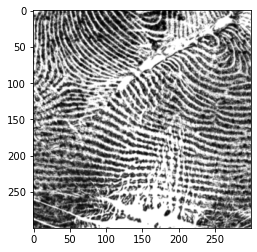

In [92]:
plt.imshow(im, cmap='gray')
plt.show()

In [93]:
from albumentations import Lambda, Resize, Compose
from albumentations.pytorch import ToTensorV2

In [188]:
image_size = im.shape[0]
def get_transformations(train=True):
    def repeat_channel(image, **kwargs):
        #print(image.shape)
        im_3ch = np.concatenate((image,)*3, axis=-1)
        print(im_3ch.shape)
        return im_3ch
    if train:
        return Compose([
            #Lambda(image=repeat_ch, name='repeat'),
            Lambda(image=repeat_channel,  name='grey-3-channels', p=1.),
            #Resize(image_size, image_size, interpolation=cv2.INTER_CUBIC, p=1.)
            ToTensorV2(p=1.0),

        ], p=1.)

In [190]:
im = cv2.imread(imPath, 0)
print(im.shape)
im = np.expand_dims(im, axis=-1)
print(im.shape)
imA = get_transformations()(image=im)['image']
print(imA.shape)

(300, 300)
(300, 300, 1)
(300, 300, 3)
torch.Size([3, 300, 300])


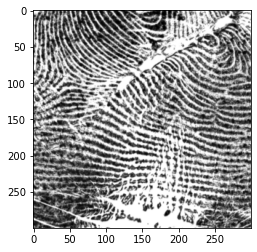

In [85]:
plt.imshow(imA)
plt.show()

In [113]:
import pywt

In [219]:
im = cv2.imread(imPath, 0)
img_blur = cv2.GaussianBlur(im, (3,3), 0)
canny = cv2.Canny(img_blur, 75, 150)
sobelxy = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=3)

In [226]:
print(sobelxy.shape)
print(im.shape)
print(canny.shape)

(300, 300)
(300, 300)
(300, 300)


In [227]:
imm = cv2.merge([im, sobelxy, canny])

error: OpenCV(4.3.0) /io/opencv/modules/core/src/merge.dispatch.cpp:129: error: (-215:Assertion failed) mv[i].size == mv[0].size && mv[i].depth() == depth in function 'merge'


In [222]:
print(max(canny.flatten()))
print(min(canny.flatten()))

255
0


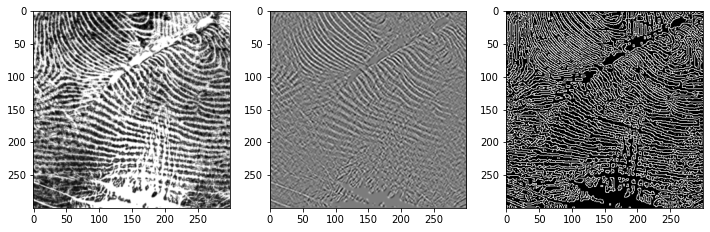

In [220]:
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(im, cmap=plt.cm.gray)
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(sobelxy, cmap=plt.cm.gray)
ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(canny, cmap=plt.cm.gray)

[]

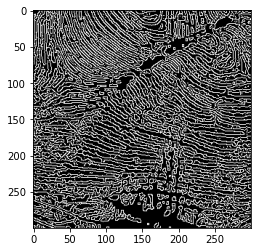

In [215]:
ax = plt.subplots
plt.imshow(canny, cmap='gray')
plt.plot()

In [143]:
im = cv2.imread(imPath, 0)
print(im.shape)
#im = np.expand_dims(im, axis=-1)
coeffs2 = pywt.dwt2(im, 'bior1.3')

(300, 300)


In [144]:

LL, (LH, HL, HH) = coeffs2

In [228]:
LH.shape

(152, 152)

In [208]:
#imWL = np.array([LH, HL, HH])
imWL = cv2.merge([LH, HL, HH])
#imWL = np.moveaxis(imWL, 0, -1)

In [209]:
norm_imWL = cv2.normalize(imWL, None, alpha=0, beta=255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8S)

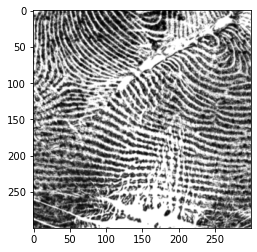

In [198]:
plt.imshow(im, cmap='gray')
plt.savefig('gray.png')
plt.show()

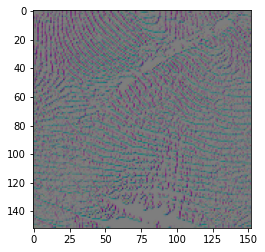

In [210]:
plt.imshow(norm_imWL) #, cmap='gray')
plt.savefig('wavelets.png')
plt.show()

(152, 152)
(152, 152)
(152, 152)
(152, 152)
(152, 152)


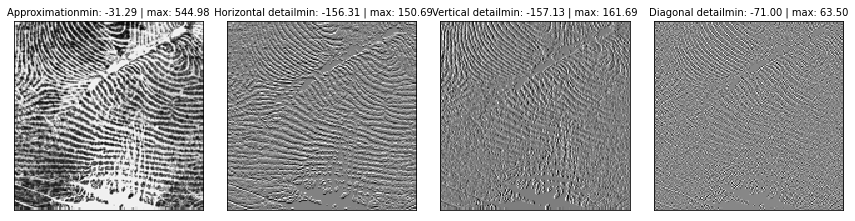

In [204]:
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
fig = plt.figure(figsize=(12, 3))
imtotal = np.zeros_like(LL)
print(imtotal.shape)
for i, a in enumerate([LL, LH, HL, HH]):
    print(a.shape)
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    #ax = fig.add_subplot(2, 4, i + 1)
    #a = cv2.normalize(a, None, alpha=0, beta=255,  norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8S)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i] + f'min: {min(a.flatten()):.2f} | max: {max(a.flatten()):.2f}', fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

In [192]:
image_size = im.shape[0]
def get_transformations(train=True):
    def repeat_channel(image, **kwargs):
        #print(image.shape)
        im_3ch = np.concatenate((image,)*3, axis=-1)
        print(im_3ch.shape)
        return im_3ch
    if train:
        return Compose([
            #Lambda(image=repeat_ch, name='repeat'),
            #Lambda(image=repeat_channel,  name='grey-3-channels', p=1.),
            #Resize(image_size, image_size, interpolation=cv2.INTER_CUBIC, p=1.)
            ToTensorV2(p=1.0),

        ], p=1.)

In [193]:
norm_imWL.shape

(152, 152, 3)

In [194]:
norm_imWL_alb = get_transformations()(image=norm_imWL)['image']

In [195]:
norm_imWL_alb.shape

torch.Size([3, 152, 152])

In [187]:
norm_imWL_alb

tensor([[[127, 127, 126,  ..., 127, 127, 127],
         [124, 124, 126,  ..., 116, 109, 109],
         [126, 126, 127,  ..., 127, 127, 127],
         ...,
         [ 81,  81,  86,  ..., 127, 114, 114],
         [127, 127, 126,  ...,  51,  51,  51],
         [118, 118, 125,  ..., 127, 127, 127]],

        [[127, 123, 127,  ..., 125, 127, 122],
         [127, 123, 127,  ..., 125, 127, 122],
         [126, 125, 123,  ..., 125, 116, 127],
         ...,
         [127, 118, 127,  ..., 127, 113, 127],
         [126, 125, 127,  ..., 101, 119, 127],
         [126, 125, 127,  ..., 101, 119, 127]],

        [[124, 127, 125,  ..., 126, 123, 127],
         [127, 124, 126,  ..., 125, 127, 123],
         [126, 125, 127,  ..., 124, 127, 119],
         ...,
         [106, 127, 106,  ..., 127, 127, 118],
         [127, 113, 127,  ..., 127, 111, 127],
         [113, 127, 106,  ..., 108, 127, 111]],

        ...,

        [[127, 127, 126,  ..., 127, 127, 127],
         [124, 124, 126,  ..., 116, 109, 109]